In [1]:
# ---------------------------------------------------------------------
# 모델링 관련 모듈 로딩
# ---------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torchinfo import summary

from torchmetrics.regression import R2Score, MeanSquaredError
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassConfusionMatrix
import torch.optim.lr_scheduler as lr_scheduler

import torchvision.models as models

# ---------------------------------------------------------------------
# 데이터 분석 관련 모듈 로딩
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 이미지 관련 모듈 로딩
# ---------------------------------------------------------------------
import cv2
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from torchvision import datasets

# ---------------------------------------------------------------------
# 기타 모듈 로딩
# ---------------------------------------------------------------------
import time
import os

# 활용 패키지 버전 체크
print(f'torch Ver.:{torch.__version__}')
print(f'pandas Ver.:{pd.__version__}')
print(f'numpy Ver.:{np.__version__}')

torch Ver.:2.2.2
pandas Ver.:2.2.1
numpy Ver.:1.26.4


In [2]:
# DEVICE 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

- 이미지 파일 => 하나로 합치기 <hr>

In [3]:
## 이미지 파일 => 하나로 합치기
## 데이터 관련 설정
IMG_PATH = r'./data_all2_class/'

- Tensor ==> Ndarray <hr>

In [4]:
## 데이터 변형 및 전처리
# transConvert = v2.Compose([
#     v2.Resize([180, 180]),
#     v2.RandomResizedCrop(120),
#     v2.ToTensor(),
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     v2.ToDtype(torch.float32, scale=True)
# ])

transConvert = {
    'Train': v2.Compose([
    v2.Resize([180, 180]),
        v2.CenterCrop(224),
    v2.RandomVerticalFlip(p=0.7),
    v2.RandomHorizontalFlip(p=0.7),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.ToDtype(torch.float32, scale=True)
]),
    'Test': v2.Compose([
    v2.Resize([180, 180]),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.ToDtype(torch.float32, scale=True)
])

}

c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
## 이미지 데이터셋 생성
imgDS=ImageFolder(root=IMG_PATH, transform=transConvert['Train'])

In [6]:
print(f'imgDS.classes       : {imgDS.classes}')
print(f'imgDS.class_to_idx  : {imgDS.class_to_idx}')
print(f'imgDS.targets       : {imgDS.targets}')
for img in imgDS.imgs:
    print(f'imgDS.imgs       : {img}')
    break

imgDS.classes       : ['shani', 'shuya', 'toshim']
imgDS.class_to_idx  : {'shani': 0, 'shuya': 1, 'toshim': 2}
imgDS.targets       : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
class_names = imgDS.classes

In [8]:
# imgDL=DataLoader(imgDS, batch_size=32)

In [9]:
len(imgDS)

6056

In [10]:
# train, test 분리

# 모듈 로딩
from torch.utils.data import random_split
trainDS, validDS, testDS = random_split(imgDS, [3636,1210,1210])

trainDL=DataLoader(trainDS, batch_size=32)
validDL=DataLoader(validDS, batch_size=32)
testDL=DataLoader(testDS, batch_size=32)

In [11]:
# for data, target in imgDL:
#     print(data.shape)
#     print(target.shape)
#     break

In [12]:
### 사전학습된 모델 로딩
model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

In [13]:
### 모델 구조 확인 
print(model)
# summary(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
### 사전학습된 모델의 파라미터 비활성화 설정
for named, param in model.named_parameters():
    # print(f'[{named}] - {param.shape}')
    
    # 역전파 시에 업데이트 되지 않도록 설정
    param.requires_grad=False

In [15]:
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)
)

In [16]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=3, bias=True)
  )
)


In [17]:
### classifier 파라미터 활성화 설정
for named, param in model.classifier[6].named_parameters():
    print(f'[{named}] - {param.shape}')
    param.requires_grad=True

[0.weight] - torch.Size([512, 4096])
[0.bias] - torch.Size([512])
[3.weight] - torch.Size([3, 512])
[3.bias] - torch.Size([3])


In [18]:
model=model.to(DEVICE)

In [19]:
# print(model)

In [20]:
# 최적화 인스턴스
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=0.01)

# 손실함수 인스턴스
loss_func = torch.nn.CrossEntropyLoss()

# 최적화 스케쥴링 인스턴스 생성 => lr 조절 및 성능 개선 여부 체크
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=15, verbose=True) # score 사용 시


c:\Users\DELL-PC\.conda\envs\EXAM_DL\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [21]:
def train_model(model, loss_func, optimizer, DEVICE, num_epochs=1, is_train=True):
    f1score_func = MulticlassF1Score(num_classes=3).to(DEVICE)
    since = time.time()
    loss_history = [],[]
    acc_history = [],[]
    best_acc = 0.0
    # num_epochs = 5

    for epoch in range(num_epochs):
        # 학습 모드로 모델 설정
        model.train()

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        running_corrects = 0
        running_loss = 0.0
        
        score_total = 0

        for featureTS, targetTS in trainDL:

            # DEVICE : CPU/GPU 사용
            featureTS=featureTS.to(DEVICE)
            targetTS=targetTS.to(DEVICE)
            
            # 학습 진행
            pre_y = model(featureTS)

            # 손실 계산
            loss = loss_func(pre_y, targetTS)

            # # 예제 점수계산법
            _, preds = torch.max(pre_y, 1)

            # 성능평가 계산
            score=f1score_func(pre_y, targetTS.reshape(-1))
            score_total += score.item()

            # 최적화 진행
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_corrects += torch.sum(preds == targetTS.data)
            # running_loss += loss.item() * featureTS.size(0) # loss값 * batch_size
            running_loss += loss.item() 

        # 검증 모드로 모델 설정
        model.eval()

        running_val_corrects = 0
        running_val_loss = 0.0
        
        with torch.no_grad():
            # 검증 데이터셋
            for feature, target in validDL:
                
                # CPU/GPU 사용
                feature=feature.to(DEVICE)
                target=target.to(DEVICE)

                # 평가
                pre_val=model(feature)

                # 손실
                loss_val=loss_func(pre_val, target.reshape(-1).long())

                # 성능평가
                score_val=f1score_func(pre_val, target.reshape(-1))
            
            running_val_corrects+=score_val.item()
            running_val_loss+=loss_val.item()

        epoch_acc = running_corrects.double() / len(trainDL)
        epoch_loss = running_loss / len(trainDL)

        print('[TRAIN] LOSS: {:.4f} SCORE: {:.4f}'.format(epoch_loss, score_total/len(trainDL))) 
        print('[VAL] LOSS: {:.4f} SCORE: {:.4f}'.format(running_val_loss, running_val_corrects))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        loss_history[0].append(epoch_loss)        
        acc_history[0].append(score_total/len(trainDL))

        loss_history[1].append(running_val_loss)
        acc_history[1].append(running_val_corrects)

        ### 모델 저장 부분
        # 끝나는 시간 저장
        end_time = time.strftime('%y.%m.%d..%H_%M_%S')

        # 모델 파라미터 저장
        if len(acc_history[1]) == 1:
            torch.save(model.state_dict(), os.path.join('./models/', '{0:0=2d}_{1}.pth'.format(epoch+1, end_time)))
        else:
            if acc_history[1][-1] > max(acc_history[1][:-1]):
                torch.save(model.state_dict(), os.path.join('./models/', '{0:0=2d}_{1}.pth'.format(epoch+1, end_time)))
        print()

        # 모델 경로 지정
        SAVE_PATH = './models'
        SAVE_MODEL = f'/model_num_loss({running_val_loss:.4f})_score({running_val_corrects:.4f}).pth'
        
        # 모델 전체 저장
        if len(acc_history[1]) == 1:
            torch.save(model, SAVE_PATH+SAVE_MODEL)
        else:
            if acc_history[1][-1] > max(acc_history[1][:-1]):
                torch.save(model, SAVE_PATH+SAVE_MODEL)

        # 최적화 스케쥴러 인스턴스 업데이트
        scheduler.step(loss_val)
        print(f'scheduler.num_bad_epochs => {scheduler.num_bad_epochs}', end=' ')
        print(f'scheduler.patience => {scheduler.patience}')

        # # 손실 감소(또는 성능 개선)이 안되는 경우 조기종료
        # if scheduler.num_bad_epochs >= scheduler.patience:
        #     print(f'{scheduler.patience}EPOCH 성능 개선이 없어서 조기종료함')
        #     break

    time_elapsed = time.time() - since
    print('모델 학습 시간: {:.0f}분 {:.0f}초'.format(time_elapsed // 60, time_elapsed % 60))
    
	### 학습 & 검증 결과 그래프로 출력
    epochs = range(1, len(acc_history[1]) + 1)
    
	# Loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history[0], 'r-', label='Train')
    plt.plot(epochs, loss_history[1], 'b-', label='Valid')
    plt.grid()
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_history[0], 'r-', label='Train')
    plt.plot(epochs, acc_history[1], 'b-', label='Valid')
    plt.grid()
    plt.title('F1_Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1_Score')
    plt.legend()
    


Epoch 1/20
----------
[TRAIN] LOSS: 0.9184 SCORE: 0.7117
[VAL] LOSS: 0.4281 SCORE: 0.7768

scheduler.num_bad_epochs => 0 scheduler.patience => 15
Epoch 2/20
----------
[TRAIN] LOSS: 0.5206 SCORE: 0.7968
[VAL] LOSS: 0.1119 SCORE: 0.9434

scheduler.num_bad_epochs => 1 scheduler.patience => 15
Epoch 3/20
----------
[TRAIN] LOSS: 0.5614 SCORE: 0.7750
[VAL] LOSS: 0.2769 SCORE: 0.8541

scheduler.num_bad_epochs => 2 scheduler.patience => 15
Epoch 4/20
----------
[TRAIN] LOSS: 0.5481 SCORE: 0.7788
[VAL] LOSS: 0.4861 SCORE: 0.7652

scheduler.num_bad_epochs => 0 scheduler.patience => 15
Epoch 5/20
----------
[TRAIN] LOSS: 0.5302 SCORE: 0.7808
[VAL] LOSS: 0.3362 SCORE: 0.8089

scheduler.num_bad_epochs => 1 scheduler.patience => 15
Epoch 6/20
----------
[TRAIN] LOSS: 0.5304 SCORE: 0.7787
[VAL] LOSS: 0.2585 SCORE: 0.9126

scheduler.num_bad_epochs => 2 scheduler.patience => 15
Epoch 7/20
----------
[TRAIN] LOSS: 0.4921 SCORE: 0.7973
[VAL] LOSS: 0.3213 SCORE: 0.7723

scheduler.num_bad_epochs => 3 sch

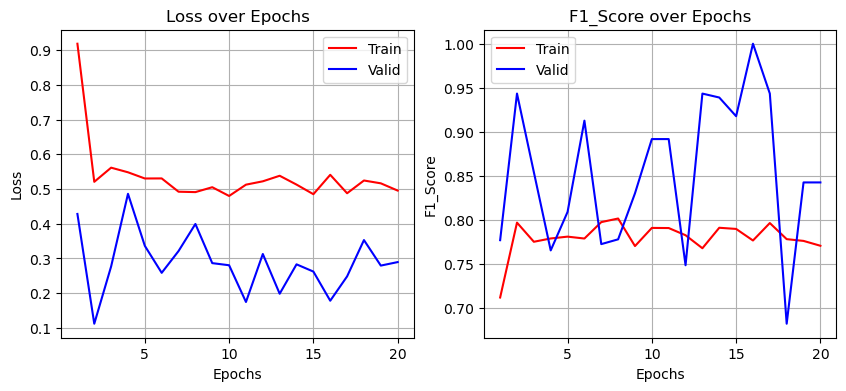

In [22]:
train_model(model, loss_func, optimizer, DEVICE, num_epochs=20, is_train=True)